# Hpol deconvolution + attempt at polarization reco

### Sep 15, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util

Welcome to JupyROOT 6.18/04


In [103]:
mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Define function

## Antenna deconvolution

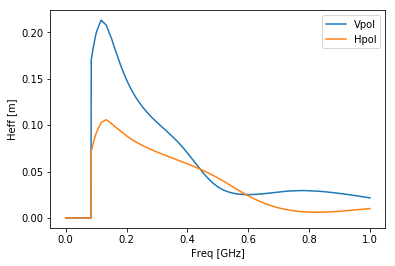

In [3]:
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
freq = np.linspace(0,1,1000)
resp = antV.antenna.frequency_response(freq*1E9)*antV.antenna.directional_response(theta=np.pi/2, phi=0, polarization=[0,0,1])(freq*1E9)
resp2 = antH.antenna.frequency_response(freq*1E9)*antH.antenna.directional_response(theta=np.pi/2, phi=0, polarization=[0,1,0])(freq*1E9)
plt.plot(freq,abs(resp), label="Vpol")
plt.plot(freq,abs(resp2), label="Hpol")
plt.xlabel("Freq [GHz]")
plt.ylabel("Heff [m]")
# plt.xlim(0,0.1)
plt.legend()

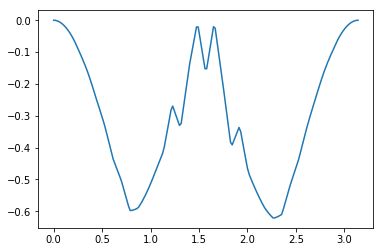

In [4]:
thetas = np.linspace(0,np.pi,180)
resp=[]
for theta in thetas:
    resp.append(antV.antenna.directional_response(theta=theta, phi=0, polarization=[0,0,1])(0.4*1E9))
# resp2 = antH.antenna.directional_response(theta=thetas, phi=0, polarization=[0,1,0])(0.4*1E9)
# plt.plot(thetas,abs(resp), label="Vpol")
# plt.plot(thetas,abs(resp2), label="Hpol")
# plt.xlabel("Freq [GHz]")
# plt.ylabel("Heff [m]")
# # plt.xlim(0,0.1)
# plt.legend()
plt.plot(thetas,resp)

In [5]:
# def deConvolve_antenna(time, voltage, theta, phi, pol_ant):
#     import scipy.signal as signal
#     if(pol_ant == 0):
#         ant = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
#         polarization=np.array([0,0,1])
#     if(pol_ant == 1):
#         ant = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
#         polarization=[0,1,0]
#     sampRate = len(time)/(max(time)-min(time))
#     b,a = signal.bessel(4, [0.15,0.4], 'bandpass', analog=False, fs=sampRate)
#     fft_v, fft_f, dT = util.doFFT(time,voltage)
#     response_filter = np.array(util.interpolate_filter(fft_f*1E6))
#     dir_res = ant.antenna.directional_response(theta=theta, phi=phi, polarization=polarization)(fft_f*1E6)
#     heff = ant.antenna.frequency_response(fft_f*1E6)
#     response_antenna = dir_res*heff
#     response = response_antenna
#     deDis_wf = np.divide(fft_v,abs(response))
#     response = np.divide(response,abs(response))
#     deDis_wf = np.divide(deDis_wf,response)
#     deDis_wf = np.nan_to_num(deDis_wf)
#     revert = util.doInvFFT(deDis_wf)
#     deDis_wf = signal.lfilter(b, a, revert)
#     return time, deDis_wf
#     #vetted!
    

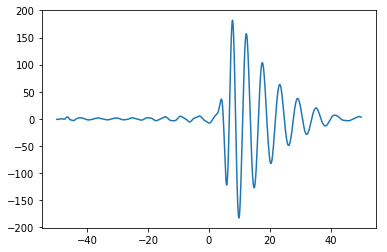

In [17]:
# phi = np.deg2rad(90)
# theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
# dirProp = np.array([0,1,0])
dirProp = random_three_vector()
pol_ev
phi = np.arctan2(dirProp[1],dirProp[0])
theta = np.arccos(dirProp[2])
wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV
plt.plot(timeV,voltageV)

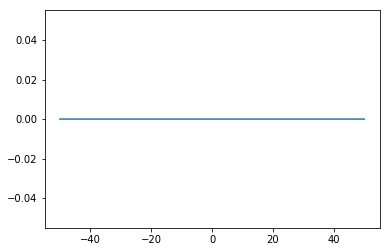

In [18]:
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeH,voltageH)

Text(0,0.5,'Voltage [mV]')

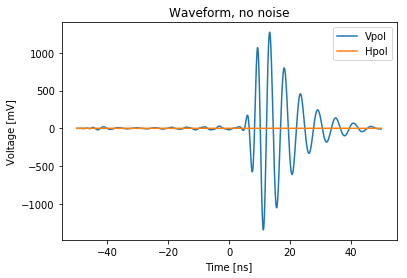

In [19]:
deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)

plt.plot(deConv_V_t,deConv_V_v, label = "Vpol")
plt.plot(deConv_H_t,deConv_H_v, label = "Hpol")
plt.legend()
plt.title("Waveform, no noise")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]")

### Calculate polarization angle from Stokes parameters

In [20]:
def PolAngleStokes(Hpol,Vpol):
    return np.degrees(0.5*np.arctan2(2*Hpol*Vpol,(Hpol**2-Vpol**2)))

In [21]:
def PolRatio(Hpol,Vpol):
    return np.degrees(np.arctan(Hpol/Vpol))

In [22]:
angle_Stokes = PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))

In [23]:
angle_true = np.degrees(np.arccos(pol_ev[2]))+90

(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.]),
 array([-0.5 , -0.45, -0.4 , -0.35, -0.3 , -0.25, -0.2 , -0.15, -0.1 ,
        -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,
         0.4 ,  0.45,  0.5 ]),
 <a list of 20 Patch objects>)

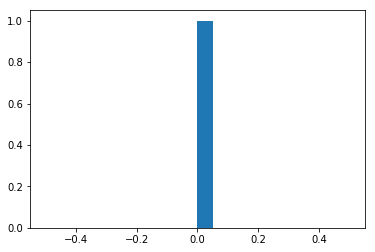

In [24]:
plt.hist(angle_Stokes-angle_true, bins=20)

# Generate random polarizations

In [59]:
def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    phi = np.random.uniform(0,np.pi)
    costheta = np.random.uniform(0,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return np.array([x,y,z])

In [86]:
reco=[]
true=[]

antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
for count in range(0,5000):
#     dirProp = np.array([1/np.sqrt(2),0,1/np.sqrt(2)])
    dirProp =  random_three_vector()
    pol_ev = np.random.randn(3)  # take a random vector
    pol_ev -= pol_ev.dot(dirProp) * dirProp       # make it orthogonal to k
    pol_ev /= np.linalg.norm(pol_ev) 

    phi = np.arctan2(dirProp[1],dirProp[0])
    theta = np.arccos(dirProp[2])
#     pol_ev = random_three_vector()
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3 #in mV

    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3 #in mV

    deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)

    reco.append(PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v))))
    true.append(np.degrees(np.arccos(pol_ev[2]))+90)
#     print((PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))-np.degrees(theta)))

In [87]:
reco=np.array(reco)
true =np.array(true)

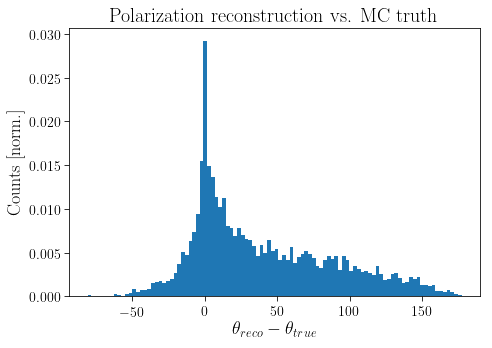

In [113]:
plt.figure(figsize=(7,5))
plt.hist(reco-true+180, bins=100, density=True);
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
plt.tight_layout()
plt.savefig("./plots/Stokes/recoVsTrue_MC.png", dpi=200)

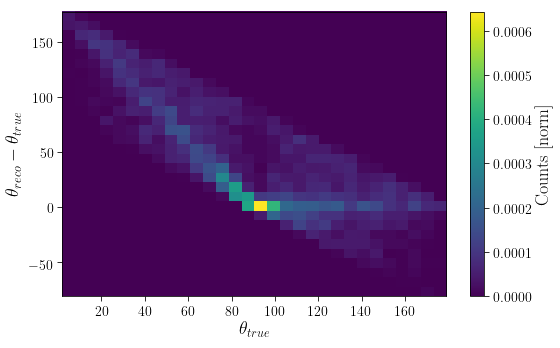

In [112]:
plt.figure(figsize=(8,5))
plt.hist2d(true-90,reco-true+180, bins=30, normed=True);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$")
plt.tight_layout()
plt.savefig("./plots/Stokes/recovsRecoMinusTrue_MC.png", dpi=200)

In [40]:
Stokes_reco = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/pol_quant.pkl")
Stokes_reco["delta"] = 90+Stokes_reco.AngStokes-np.degrees(np.arccos(Stokes_reco.pol_z))
Stokes_reco["pol_z_angle"] = 180-np.degrees(np.arccos(Stokes_reco.pol_z))
Stokes_reco.head()


,EvNum,theta_reco,theta_antenna,pol_x,pol_y,pol_z,AngStokes,AngRatio,delta,pol_z_angle
0,41,62.0,63.874833,-0.468684,0.457021,0.755955,27.838725,62.161275,76.947572,139.108847
1,70,83.0,86.413732,0.197785,0.512993,-0.835296,35.095173,54.904827,-21.551476,33.353350
2,143,71.0,72.764205,-0.153866,-0.426478,0.891315,41.621173,48.378827,104.660099,153.038926
3,331,97.0,82.471256,-0.605470,0.358202,-0.710702,20.651759,69.348241,-24.640303,44.707938
4,336,82.0,85.621076,-0.313883,0.577852,-0.753369,32.106986,57.893014,-16.776049,41.116966


In [41]:
Stokes_reco.loc[Stokes_reco['pol_z_angle'] >90 , 'pol_z_angle'] = 180-Stokes_reco.pol_z_angle
Stokes_reco.head()

,EvNum,theta_reco,theta_antenna,pol_x,pol_y,pol_z,AngStokes,AngRatio,delta,pol_z_angle
0,41,62.0,63.874833,-0.468684,0.457021,0.755955,27.838725,62.161275,76.947572,40.891153
1,70,83.0,86.413732,0.197785,0.512993,-0.835296,35.095173,54.904827,-21.551476,33.353350
2,143,71.0,72.764205,-0.153866,-0.426478,0.891315,41.621173,48.378827,104.660099,26.961074
3,331,97.0,82.471256,-0.605470,0.358202,-0.710702,20.651759,69.348241,-24.640303,44.707938
4,336,82.0,85.621076,-0.313883,0.577852,-0.753369,32.106986,57.893014,-16.776049,41.116966


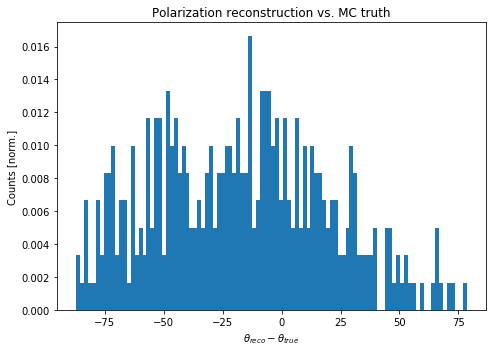

In [42]:
plt.figure(figsize=(7,5))
plt.hist(Stokes_reco.AngStokes-Stokes_reco.pol_z_angle,bins=100, normed=True);
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
plt.tight_layout()
# plt.savefig("./plots/Stokes/recovsTrue.pdf")

Text(0,0.5,'$\\theta_{reco}-\\theta_{true}$')

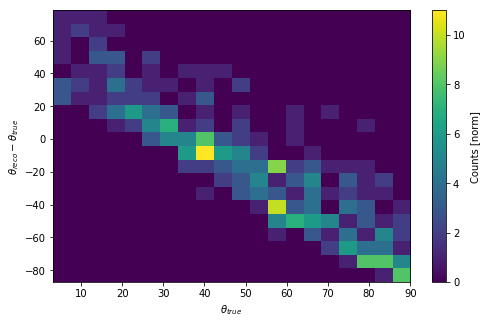

In [43]:
plt.figure(figsize=(8,5))
plt.hist2d(Stokes_reco.pol_z_angle,Stokes_reco.AngStokes-Stokes_reco.pol_z_angle, bins=20, normed=False);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$")
# plt.savefig("./plots/Stokes/recovsRecoMinusTrue.pdf")

In [ ]:
Stokes_reco.loc[Stokes_reco.EvNum==143]

In [ ]:
debug = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/pol_quant_debug.pkl")

In [ ]:
np.degrees(np.arccos(debug.pol_z))

In [ ]:
41.621173+90

In [ ]:
fig = plt.figure(figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

start, stop, n_values = 0, 1, 1000

x_vals = np.linspace(start, stop, n_values)
y_vals = 1-x_vals#np.linspace(start, stop, n_values)
X, Y = np.meshgrid(x_vals, y_vals)


Z = np.degrees(0.5*np.arctan2(2*X*Y,(X**2-Y**2)))

cp = plt.contourf(X, Y, Z,90)
# plt.clabel(cp)
plt.colorbar(cp, label="Polarization angle of incoming signal [deg]")

ax.set_title('Polarization angle from Stokes parameters')
ax.set_xlabel('$E_{hpol}$ [normalized]')
ax.set_ylabel('$E_{vpol}$ [normalized]')
# plt.show()
plt.tight_layout()
plt.savefig("./plots/Stokes/Stokes.pdf")